# 動的計画法

## 動的計画法である方策の評価関数を求める

ベルマン方程式は以下の式で表現できる。

$$
u_\pi (s) = \sum_{a, s'} \pi(a|s) p(s'|s, a) \{r(s, a, s') + \gamma u_\pi (s')\}
$$

この式は「現在の状態$s$の価値関数$u_\pi(s)$」と「次の状態$s'$の評価関数$u_\pi(s')$」の関係を表している。

これを評価関数の推定値$V_k$の更新式と捉えると以下の式で表現できる。なお、$k$は$k$回目の更新であることを表す。

$$
V_{k+1}(s) = \sum_{a, s'} \pi(a|s) p(s'|s, a) \{r(s, a, s') + \gamma V_k(s')\}\\
V_{k+1}(s) = \sum_a \pi(a|s) \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma V_k(s')\} \tag{1}
$$

これを繰り返すことで$V_k$が$u_\pi (s)$に収束することが証明されている。

## 簡単なワールドで方策評価を行う
### 問題設定
以下のようにL1とL2が隣り合ったグリッドを考える。状態L1から右(状態L2)に移動すると報酬は+1、状態L2から左(状態L1)に移動すると報酬は0である。

また、状態L1から左または状態L2から右に移動すると報酬は-1で状態は変化しない。

| L1 | L2 |

### 方策
左・右それぞれ$0.5$の確率でランダムに選択する方策を考える。

この問題では選択した行動に対して次の状態が一意に決まる決定論的な問題であるため、$s' = f(s, a)$より以下の式で表現できる。

$$
V_{k + 1} (s) = \sum_a \pi (a|s) \{r(s, a, s') + \gamma V_k (s')\} \tag{2}
$$

まず、$V_0(L1) = 0, V_0(L2) = 0$で初期化する。

In [24]:
# 方策評価を行うプログラム
V = {"L1": 0, "L2": 0}
gamma = 0.9

for k in range(1, 101):
    # 式(2)に基づいて方策評価を計算
    V["L1"] = 0.5 * (-1 + gamma * V["L1"]) + 0.5 * (1 + gamma * V["L2"])
    V["L2"] = 0.5 * (0 + gamma * V["L1"]) + 0.5 * (-1 + gamma * V["L2"])
    print(V)

{'L1': 0.0, 'L2': -0.5}
{'L1': -0.22499999999999998, 'L2': -0.8262499999999999}
{'L1': -0.47306249999999994, 'L2': -1.084690625}
{'L1': -0.70098890625, 'L2': -1.3035557890625}
{'L1': -0.902045112890625, 'L2': -1.4925204058789063}
{'L1': -1.0775544834462891, 'L2': -1.656533700196338}
{'L1': -1.2303396826391824, 'L2': -1.7990930222759842}
{'L1': -1.363244717211825, 'L2': -1.9230519827695143}
{'L1': -1.4788335149916028, 'L2': -2.030848473992503}
{'L1': -1.5793568950428476, 'L2': -2.1245924160659078}
{'L1': -1.6667771899989399, 'L2': -2.2061163227291813}
{'L1': -1.7428020807276545, 'L2': -2.2770132815555764}
{'L1': -1.808916913027454, 'L2': -2.338668587562364}
{'L1': -1.8664134752654182, 'L2': -2.392286928272502}
{'L1': -1.916415181592064, 'L2': -2.4389159494390547}
{'L1': -1.9598990089640036, 'L2': -2.4794667312813763}
{'L1': -1.997714583110421, 'L2': -2.514731591476309}
{'L1': -2.0306007785640285, 'L2': -2.545399566518152}
{'L1': -2.059200155286981, 'L2': -2.57206987481231}
{'L1': -2.084

## 結果の確認
問題設定より、ランダムに行動を選択する方策の真の評価関数の値は以下のようになる。

$$
u(L1) = -2.25, u(L2) = -2.75
$$

このことから、上記のプログラムを用いることで高い精度で評価関数の値を得られることがわかる。

また、上記プログラムでは更新回数を100回としていたが、更新前と更新後の値の絶対値が一定以下になると終了とすることができる。

## より大きな問題への適用

$3 \times 4$のグリッドマスについて考える。左上を$(0, 0)$とし、ルールは以下の通りである。

- グリッド内を上下左右に移動できる
- $(1, 1)$に壁があり、ここに移動することはできない
- 壁に当たった場合の報酬は$0$で状態は変化しない
- $(0, 3)$に移動すると報酬$+1$を得る
- $(1, 3)$に移動すると報酬$-1$を得る
- $(2, 0)$を初期位置、$(0, 3)$をゴールとする

この問題は終わりのあるエピソードタスクである。

### プログラムの設計
`GridWorld`クラスを実装する。

In [25]:
import numpy as np
from utils import Renderer

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 上、下、左、右
        self.action_map = {
            0: (-1, 0),  # 上
            1: (1, 0),   # 下
            2: (0, -1),  # 左
            3: (0, 1),   # 右
        }
        self.reward_map = np.array([
            [0, 0, 0, 1],
            [0, None, 0, -1],
            [0, 0, 0, 0],
        ])
        self.goal_state = (0, 3)  # ゴール地点
        self.wall_state = (1, 1)  # 壁の地点

    @property
    def height(self):
        return self.reward_map.shape[0]
    
    @property
    def width(self):
        return self.reward_map.shape[1]
    
    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space
    
    # 状態を取得
    def states(self):
        for i in range(self.height):
            for j in range(self.width):
                yield (i, j)
                
    def next_state(self, state, action):
        move = self.action_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        nx, ny = next_state
        
        # ワールドの端なら状態は変わらない
        if nx < 0 or nx >= self.height or ny < 0 or ny >= self.width:
            return state
        # 壁なら状態は変わらない
        elif self.reward_map[nx, ny] is None:
            return state
        
        return next_state
    
    def reward(self, state):
        return self.reward_map[state]
    
    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state, self.wall_state)
        renderer.render_v(v, policy, print_value)

In [26]:
from collections import defaultdict


def eval_step(pi: defaultdict[tuple[int, int], dict[int, float]], V: defaultdict, env: GridWorld, gamma: float):
    """
    方策評価の1ステップを実行する関数
    pi: 方策 pi[state] -> stateからの移動方向
    V: 現在の状態価値関数
    env: 環境
    gamma: 割引率
    """
    # 各地点について
    for state in env.states():
        # ゴール地点の評価関数は0
        if state == env.goal_state:
            V[state] = 0
            continue
        
        action_probs = pi[state] # 現地点の行動確率
        new_V = 0
        
        # ある地点からの各行動について
        for action, action_prob in action_probs.items():
            # 次の状態を取得
            next_state = env.next_state(state, action)
            # 報酬を取得
            reward = env.reward(next_state)
            # 次の状態の価値関数を取得
            new_V += action_prob * (reward + gamma * V[next_state])
        V[state] = new_V
    return V

defaultdict(<function <lambda> at 0x0000020C100B5E40>, {(0, 0): 0.0256663947864485, (1, 0): -0.03181367353370739, (0, 1): 0.09455374934534977, (0, 2): 0.20546499234745147, (1, 2): -0.49795210910078397, (0, 3): 0, (2, 0): -0.10343315257870167, (2, 1): -0.221022921886541, (1, 1): -0.14765286489289256, (2, 2): -0.4368451010901099, (1, 3): -0.3726771560319816, (2, 3): -0.7857136506161768})


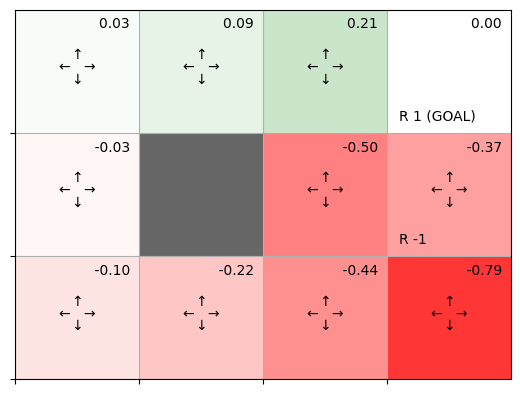

In [27]:
env = GridWorld()
gamma = 0.9

# ランダムに移動する方策
pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
V = defaultdict(lambda: 0)

def policy_eval(pi: defaultdict[tuple[int, int], dict[int, float]], V: defaultdict, env: GridWorld, gamma: float, threshold: float = 1e-10):
    """
    方策評価を行う関数
    pi: 方策 pi[state] -> stateからの移動方向
    V: 現在の状態価値関数
    env: 環境
    gamma: 割引率
    threshhold: 収束判定の閾値
    """
    while True:
        # 方策評価の1ステップを実行
        V_prev = V.copy()
        V = eval_step(pi, V, env, gamma)
        # 収束判定
        if max([abs(V[state] - V_prev[state]) for state in V.keys()]) < threshold:
            break
    return V

print(policy_eval(pi, V, env, gamma))
env.render_v(V, pi, print_value=True)

## 結果の確認
報酬がマイナスのマスに近いほど、評価関数の値が小さくなっていることがわかる。

このことから、正しく評価関数の値を得られたと考えられる。

## 方策反復法
ここまで、ある方策に対して評価関数を求める方法を考えてきたが、最適方策を求めたい。

まず、最適方策は以下の式で表すことができる。

$$\begin{align*}
\mu_* (s) &= \argmax_a q_* (s, a)\\
&= \argmax_a \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma u_\mu(s')\}
\end{align*}$$

これは、状態$s$のときに行動価値関数を最大化する行動のインデックスを表す。

ここで、以下のようにして方策を更新することを考える。
$$\begin{align*}
\mu '(s) &= \argmax_a q_\mu (s, a)\\
&= \argmax_a \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma u_\mu(s')\}
\end{align*}$$

この式は現状の方策$\mu(s)$における状態価値関数$u_\mu(s)$を用いて、新たな方策$\mu' (s)$を導く。

すべての状態$s$について$\mu(s)$と$\mu'(s)$が同じであれば(方策が更新されなければ)、方策$\mu(s)$が最適方策。

### 実例を考える
先ほどと同じ$3 \times 4$のグリッドマスの問題について考える。

この問題は決定論的で、状態$s$と行動$a$に対して次の状態が一意に決まる。そのため、方策の更新式は以下のようにして表すことができる。

$$
\mu' (s) = \argmax_a \{r(s, a, s') + \gamma u_\mu (s')\}
$$

この式に従って方策を更新する`greedy_policy`関数を以下に定義する。

In [28]:
def argmax(d: dict):
    """
    辞書の最大値を持つキーを返す関数
    d: 辞書
    """
    return max(d, key=d.get)

def greedy_policy(V: defaultdict, env: GridWorld, gamma: float):
    """
    V: 状態価値関数
    env: 環境
    gamma: 割引率
    """
    pi = {}
    
    # 各地点について
    for state in env.states():
        action_values = {}
        
        # 各行動の価値を計算
        for action in env.actions():
            next_state = env.next_state(state, action)
            reward = env.reward(next_state)
            action_values[action] = reward + gamma * V[next_state]

        # 価値が最大となる行動を選択
        max_action = argmax(action_values)
        action_probs = {a: 0 for a in env.actions()}
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    return pi

評価関数値の更新(`policy_eval`)と方策の更新(`greedy_policy`)を交互に繰り返す`policy_iter`関数を以下のように定義する。

In [31]:
# 方策反復法
def policy_iter(env: GridWorld, gamma: float, threshold: float = 1e-10, render: bool = False) -> tuple[defaultdict, defaultdict]:
    # 方策と評価関数値の初期化
    pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
    V = defaultdict(lambda: 0)
    
    while True:
        V = policy_eval(pi, V, env, gamma, threshold)
        new_pi = greedy_policy(V, env, gamma)
        
        if render:
            env.render_v(V, pi)
            
        if new_pi == pi:
            break
        
        pi = new_pi
    
    return (pi, V)

`policy_iter`を実行する

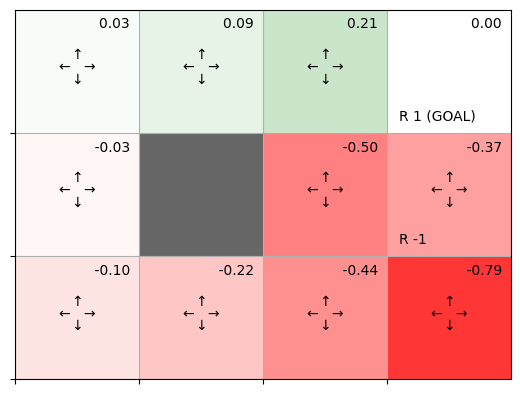

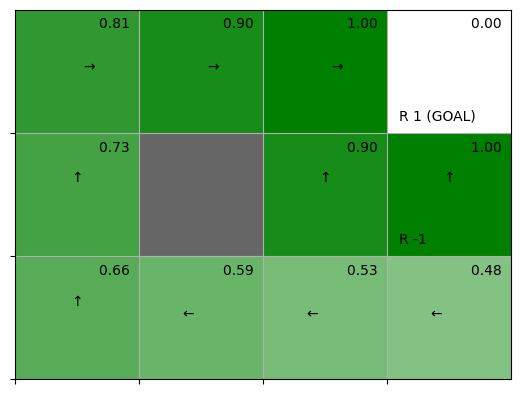

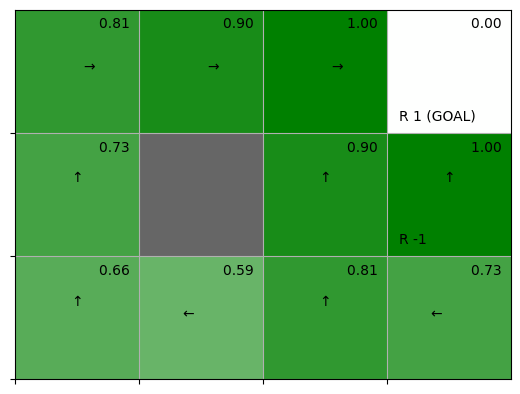

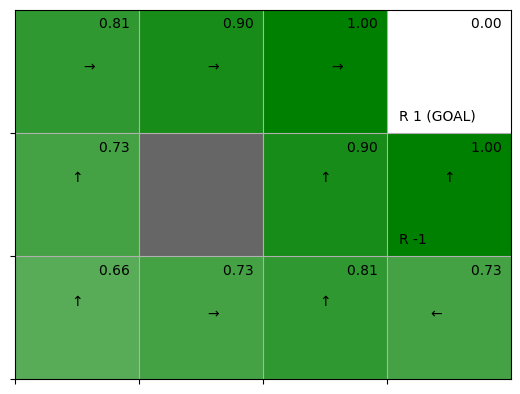

In [32]:
env = GridWorld()
gamma = 0.9
pi, V = policy_iter(env, gamma, render=True)

### 考察
方策反復法を用いることで、4回の更新で最適な方策を得ることができた。

1回目の更新でほとんど最適な方策を得ており、少しずつ方策の更新量が少なくなると考えられる。

## 価値反復法
方策反復法では、全ての状態について評価関数値の更新と方策の更新をそれぞれ最大限まで行い、交互に繰り返すことを繰り返している。

価値反復法では1つの状態について評価関数値の更新と方策の更新を行い、これを繰り返す。

### 価値反復法のアイデア
まず、評価関数値が最大となるように方策を決める式は以下であった。

$$
\mu(s) = \argmax_a \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma V(s')\}\tag{3}
$$

また、価値関数の値の更新式は以下で表される。

$$
V'(s) = \sum_{a, s'} \pi(a|s) p(s'|s, a) \{r(s, a, s') + \gamma V(s')\}\tag{4}
$$

そして、一度方策を更新した場合は決定論的な方策であるため、評価関数の値の更新式は以下のように書ける。

$$
a = \mu(s) として\\
V'(s) = \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma V(s')\}\tag{5}
$$

式(3)と式(5)を見ると、全く同じ計算をしていることがわかる。そこで、これらを1つの式にまとめることを考える。

$$
V'(s) = \max_a \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma V(s')\}\tag{6}
$$

各行動の評価関数の値において最大となるものを選択している。方策$\mu$は式に登場せず、最適価値関数$V_*$から以下のようにして最適方策を得ることができる。

$$
\mu_*(s) = \argmax_a \sum_{s'} p(s'| s, a) \{r(s, a, s') + \gamma V_*(s')\}
$$

このことから、価値反復法では以下の手順で最適方策を得ることができる。

1. 最適価値関数を求める
2. 最適方策を求める

方策反復法では最適価値関数と最適方策を同時に求めるのに比べ、価値反復法では先に最適価値関数を求めてから最適方策を得ている。

### 価値反復法の実装
まずは、各状態について価値関数値の最大値を求める`value_iter_onestep`関数を実装する。

In [33]:
def value_iter_onestep(V: defaultdict, env: GridWorld, gamma: float) -> defaultdict:
    for state in env.states(): # 各状態(地点)について
        if state == env.goal_state: # ゴール地点の評価関数は0
            V[state] = 0
            continue
        
        action_values = []
        for action in env.actions(): # 各行動について
            next_state = env.next_state(state, action)
            reward = env.reward(next_state)
            value = reward + gamma * V[next_state]
            action_values.append(value)
        
        V[state] = max(action_values) # 最大値を取り出す
        
    return V

続いて、`value_iter_onestep`関数を繰り返し実行して変化が一定以下になるまで評価関数の更新を繰り返す`value_iter`関数を実装する

In [34]:
def value_iter(V: defaultdict, env: GridWorld, gamma: float, threshold: float = 1e-10, render: bool = False) -> defaultdict:
    while True:
        if render:
            env.render_v(V)
            
        V_prev = V.copy()
        # 評価関数を更新
        V = value_iter_onestep(V, env, gamma)
        
        # 更新量の最大値を計算
        max_diff = max([abs(V[state] - V_prev[state]) for state in V.keys()])
        # 更新量の最大値が閾値より小さくなったら終了
        if max_diff < threshold:
            break
    return V
    

上記で実装した関数を使って最適評価関数を求め、その結果から最適方策を求める。

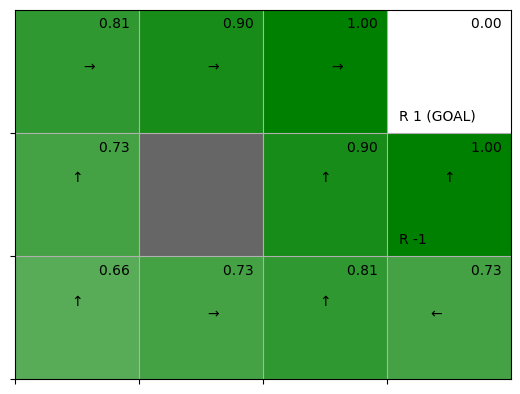

In [35]:
V = defaultdict(lambda: 0)
env = GridWorld()
gamma = 0.9

# 最適評価関数を計算
V = value_iter(V, env, gamma)

# 最適評価関数から最適方策を計算
pi = greedy_policy(V, env, gamma)

env.render_v(V, pi, print_value=True)

## 考察
価値反復法で得た結果が方策反復法で得た結果と同じになっており、この方法でも正しく結果を得ていることがわかる。

同じ計算を複数回行わないという点で若干の計算量改善になっていると考えられる。